In [1]:
!pip uninstall tensorflow

Uninstalling tensorflow-1.15.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/freeze_graph
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-1.15.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
    /usr/local/lib/python3.6/dist-packages/tensorflow_core/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-1.15.0


In [2]:
!pip install tensorflow-gpu

     |████████████████████████████████| 421.8MB 38kB/s 
     |████████████████████████████████| 450kB 50.0MB/s 
     |████████████████████████████████| 3.8MB 47.1MB/s 
     |████████████████████████████████| 81kB 12.3MB/s 
ERROR: tensorboard 2.1.0 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.0 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0


In [0]:
import tensorflow as tf

In [4]:
print(tf.version)

<module 'tensorflow_core._api.v2.version' from '/usr/local/lib/python3.6/dist-packages/tensorflow_core/_api/v2/version/__init__.py'>


In [0]:
import tensorflow_datasets as tfds

In [6]:
datasets = tfds.load("cifar10")
train_dataset, test_dataset = datasets["train"], datasets["test"]
assert isinstance(train_dataset, tf.data.Dataset)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/1.0.2. Subsequent calls will reuse this data.


In [0]:
import IPython.display as display
import numpy as np
import matplotlib.pyplot as plt
import os

In [0]:
def add_common_layers(y):
    y = layers.BatchNormalization()(y)
    y = layers.LeakyReLU()(y)

    return y

def grouped_convolution(y, nb_channels, _strides):
    # when `cardinality` == 1 this is just a standard convolution
    if cardinality == 1:
        return layers.Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)

    assert not nb_channels % cardinality
    _d = nb_channels // cardinality

    # in a grouped convolution layer, input and output channels are divided into `cardinality` groups,
    # and convolutions are separately performed within each group
    groups = []
    for j in range(cardinality):
        group = layers.Lambda(lambda z: z[:, :, :, j * _d:j * _d + _d])(y)
        groups.append(layers.Conv2D(_d, kernel_size=(3, 3), strides=_strides, padding='same')(group))

    # the grouped convolutional layer concatenates them as the outputs of the layer
    y = layers.concatenate(groups)

    return y

def residual_block(y, nb_channels_in, nb_channels_out, _strides=(1, 1), _project_shortcut=False):
    """
    Our network consists of a stack of residual blocks. These blocks have the same topology,
    and are subject to two simple rules:
    - If producing spatial maps of the same size, the blocks share the same hyper-parameters (width and filter sizes).
    - Each time the spatial map is down-sampled by a factor of 2, the width of the blocks is multiplied by a factor of 2.
    """
    shortcut = y

    # we modify the residual building block as a bottleneck design to make the network more economical
    y = layers.Conv2D(nb_channels_in, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
    y = add_common_layers(y)

    # ResNeXt (identical to ResNet when `cardinality` == 1)
    y = grouped_convolution(y, nb_channels_in, _strides=_strides)
    y = add_common_layers(y)

    y = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
    # batch normalization is employed after aggregating the transformations and before adding to the shortcut
    y = layers.BatchNormalization()(y)

    # identity shortcuts used directly when the input and output are of the same dimensions
    if _project_shortcut or _strides != (1, 1):
        # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
        # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
        shortcut = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    y = layers.add([shortcut, y])

    # relu is performed right after each batch normalization,
    # expect for the output of the block where relu is performed after the adding to the shortcut
    y = layers.LeakyReLU()(y)

    return y

In [0]:
cifar10_builder = tfds.builder('cifar10')

In [0]:
info = cifar10_builder.info

In [10]:
print(info)

tfds.core.DatasetInfo(
    name='cifar10',
    version=1.0.2,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    }""",
    redistribution_info=,
)



In [11]:
info.features['label'].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [12]:
print(tf.version)

<module 'tensorflow_core._api.v2.version' from '/usr/local/lib/python3.6/dist-packages/tensorflow_core/_api/v2/version/__init__.py'>


In [13]:
info.features['label'].int2str(0)

'airplane'

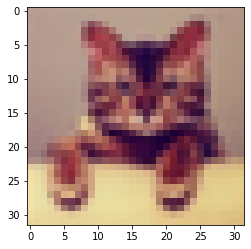

3
[[[184 159 149]
  [181 157 146]
  [182 158 145]
  ...
  [180 152 138]
  [179 151 137]
  [178 149 135]]

 [[181 157 147]
  [179 155 144]
  [179 155 142]
  ...
  [177 149 135]
  [177 149 135]
  [176 148 133]]

 [[182 158 148]
  [179 155 144]
  [179 155 143]
  ...
  [178 150 136]
  [177 149 135]
  [176 148 134]]

 ...

 [[240 227 168]
  [235 221 164]
  [233 220 162]
  ...
  [226 202 139]
  [225 199 139]
  [224 197 138]]

 [[238 221 164]
  [233 217 161]
  [233 217 160]
  ...
  [222 195 133]
  [223 193 134]
  [221 190 133]]

 [[233 216 158]
  [230 213 157]
  [231 214 158]
  ...
  [222 191 130]
  [221 188 130]
  [219 185 129]]]


In [14]:
for example in train_dataset.take(1):  # Only take a single example
    plt.imshow(example['image'].numpy())
    plt.show()
    print(example['label'].numpy())
    print(example['image'].numpy())

In [0]:
for batch in train_dataset.batch(50000):
    x_train = batch['image']
    y_train = batch['label'].numpy().astype('uint8')

In [16]:
x_train[5000].numpy()

array([[[156, 166, 181],
        [153, 166, 179],
        [153, 168, 181],
        ...,
        [ 91, 141, 173],
        [ 75, 134, 166],
        [ 61, 126, 163]],

       [[163, 172, 187],
        [160, 171, 185],
        [157, 171, 184],
        ...,
        [104, 153, 186],
        [ 91, 145, 179],
        [ 77, 137, 174]],

       [[163, 171, 184],
        [168, 178, 189],
        [161, 174, 184],
        ...,
        [117, 162, 193],
        [106, 153, 187],
        [ 94, 146, 181]],

       ...,

       [[141, 143, 148],
        [132, 140, 148],
        [131, 140, 149],
        ...,
        [171, 172, 176],
        [171, 172, 177],
        [168, 174, 181]],

       [[147, 148, 150],
        [133, 139, 147],
        [132, 139, 149],
        ...,
        [170, 171, 175],
        [171, 172, 177],
        [171, 174, 182]],

       [[154, 154, 153],
        [132, 137, 143],
        [130, 136, 145],
        ...,
        [166, 167, 172],
        [168, 170, 174],
        [169, 171, 177]]

In [17]:
y_train[5000]

0

In [18]:
y_train

array([3, 9, 3, ..., 9, 3, 7], dtype=uint8)

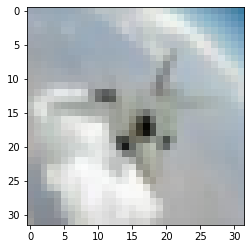

In [19]:
plt.imshow(x_train[5000].numpy())
plt.show()

In [0]:
for batch in test_dataset.batch(10000):
    x_test = batch['image']
    y_test = batch['label'].numpy().astype('uint8')

In [0]:
x_test = x_test/255
x_train = x_train/255

In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(32,32,3)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)

Train on 50000 samples
Epoch 1/5
50000/50000 [==============================] - 6s 113us/sample - loss: 7.0337 - accuracy: 0.0979
Epoch 2/5
50000/50000 [==============================] - 5s 98us/sample - loss: 2.3029 - accuracy: 0.0976
Epoch 3/5
50000/50000 [==============================] - 5s 100us/sample - loss: 2.3028 - accuracy: 0.0991
Epoch 4/5
50000/50000 [==============================] - 5s 98us/sample - loss: 2.3027 - accuracy: 0.0981
Epoch 5/5
50000/50000 [==============================] - 5s 104us/sample - loss: 2.3028 - accuracy: 0.1005


In [0]:
model.evaluate(x_test, y_test, verbose=0)

[2.3028314907073977, 0.0998]

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')  
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)

Train on 50000 samples
Epoch 1/5
50000/50000 [==============================] - 36s 724us/sample - loss: 1.7524 - accuracy: 0.3953
Epoch 2/5
50000/50000 [==============================] - 35s 708us/sample - loss: 1.3074 - accuracy: 0.5384
Epoch 3/5
50000/50000 [==============================] - 35s 702us/sample - loss: 1.1603 - accuracy: 0.5935
Epoch 4/5
50000/50000 [==============================] - 39s 775us/sample - loss: 1.0501 - accuracy: 0.6371
Epoch 5/5
50000/50000 [==============================] - 36s 729us/sample - loss: 0.9692 - accuracy: 0.6646


In [0]:
model.evaluate(x_test, y_test, verbose=0)

[1.1075871005058289, 0.6261]

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')  
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
dense_4 (Dense)              (None, 15, 15, 64)        4160      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 32)        18464     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
dense_5 (Dense)              (None, 6, 6, 32)          1056      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 64)         

In [0]:
model.fit(x_train, y_train, epochs=5)

Train on 50000 samples
Epoch 1/5
50000/50000 [==============================] - 58s 1ms/sample - loss: 1.6709 - accuracy: 0.4036
Epoch 2/5
50000/50000 [==============================] - 57s 1ms/sample - loss: 1.3217 - accuracy: 0.5277
Epoch 3/5
50000/50000 [==============================] - 60s 1ms/sample - loss: 1.1810 - accuracy: 0.5799
Epoch 4/5
50000/50000 [==============================] - 68s 1ms/sample - loss: 1.0821 - accuracy: 0.6188
Epoch 5/5
50000/50000 [==============================] - 66s 1ms/sample - loss: 1.0090 - accuracy: 0.6457


In [0]:
model.evaluate(x_test, y_test, verbose=0)

[1.238981191444397, 0.582]

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')  
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)

Train on 50000 samples
Epoch 1/5
50000/50000 [==============================] - 44s 883us/sample - loss: 1.8663 - accuracy: 0.3729
Epoch 2/5
50000/50000 [==============================] - 46s 915us/sample - loss: 1.3695 - accuracy: 0.5067
Epoch 3/5
50000/50000 [==============================] - 45s 893us/sample - loss: 1.2280 - accuracy: 0.5650
Epoch 4/5
50000/50000 [==============================] - 51s 1ms/sample - loss: 1.1153 - accuracy: 0.6066
Epoch 5/5
50000/50000 [==============================] - 57s 1ms/sample - loss: 1.0338 - accuracy: 0.6367


In [0]:
model.evaluate(x_test, y_test, verbose=0)

[1.1423063493728638, 0.5984]

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')  
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dense_10 (Dense)             (None, 15, 15, 32)        1056      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dense_11 (Dense)             (None, 6, 6, 64)          4160      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 64)         

In [0]:
model.fit(x_train, y_train, epochs=5)

Train on 50000 samples
Epoch 1/5
50000/50000 [==============================] - 53s 1ms/sample - loss: 1.5937 - accuracy: 0.4272
Epoch 2/5
50000/50000 [==============================] - 59s 1ms/sample - loss: 1.2047 - accuracy: 0.5754s - loss: 1.2061 - 
Epoch 3/5
50000/50000 [==============================] - 58s 1ms/sample - loss: 1.0540 - accuracy: 0.6292
Epoch 4/5
50000/50000 [==============================] - 59s 1ms/sample - loss: 0.9567 - accuracy: 0.6664
Epoch 5/5
50000/50000 [==============================] - 61s 1ms/sample - loss: 0.8753 - accuracy: 0.6931


In [0]:
model.evaluate(x_test, y_test, verbose=0)

[0.9590696385383606, 0.6697]

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')  
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dense_14 (Dense)             (None, 15, 15, 32)        1056      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dense_15 (Dense)             (None, 6, 6, 64)          4160      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 4, 4, 64)         

In [0]:
model.fit(x_train, y_train, epochs=10)

Train on 50000 samples
Epoch 1/10
50000/50000 [==============================] - 49s 976us/sample - loss: 1.5632 - accuracy: 0.4385
Epoch 2/10
50000/50000 [==============================] - 53s 1ms/sample - loss: 1.2201 - accuracy: 0.5667
Epoch 3/10
50000/50000 [==============================] - 49s 980us/sample - loss: 1.0712 - accuracy: 0.6242
Epoch 4/10
50000/50000 [==============================] - 47s 943us/sample - loss: 0.9691 - accuracy: 0.6588
Epoch 5/10
50000/50000 [==============================] - 48s 951us/sample - loss: 0.8933 - accuracy: 0.6878
Epoch 6/10
50000/50000 [==============================] - 42s 843us/sample - loss: 0.8317 - accuracy: 0.7078
Epoch 7/10
50000/50000 [==============================] - 40s 800us/sample - loss: 0.7829 - accuracy: 0.7240
Epoch 8/10
50000/50000 [==============================] - 41s 814us/sample - loss: 0.7454 - accuracy: 0.7402
Epoch 9/10
50000/50000 [==============================] - 43s 853us/sample - loss: 0.7035 - accuracy: 0.752

In [0]:
model.evaluate(x_test, y_test, verbose=0)

[1.0263936498641968, 0.6822]

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (1, 1), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')  
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dense_18 (Dense)             (None, 16, 16, 32)        1056      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
dense_19 (Dense)             (None, 7, 7, 32)          1056      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 5, 5, 64)         

In [0]:
model.fit(x_train, y_train, epochs=10)

Train on 50000 samples
Epoch 1/10
50000/50000 [==============================] - 33s 666us/sample - loss: 1.8375 - accuracy: 0.3539
Epoch 2/10
50000/50000 [==============================] - 35s 709us/sample - loss: 1.4302 - accuracy: 0.4881
Epoch 3/10
50000/50000 [==============================] - 35s 693us/sample - loss: 1.3007 - accuracy: 0.5371
Epoch 4/10
50000/50000 [==============================] - 39s 771us/sample - loss: 1.2067 - accuracy: 0.5731
Epoch 5/10
50000/50000 [==============================] - 39s 772us/sample - loss: 1.1279 - accuracy: 0.6020
Epoch 6/10
50000/50000 [==============================] - 37s 735us/sample - loss: 1.0656 - accuracy: 0.6235
Epoch 7/10
50000/50000 [==============================] - 38s 769us/sample - loss: 0.9985 - accuracy: 0.6474
Epoch 8/10
50000/50000 [==============================] - 39s 782us/sample - loss: 0.9344 - accuracy: 0.6708
Epoch 9/10
50000/50000 [==============================] - 39s 790us/sample - loss: 0.8801 - accuracy: 0.6

In [0]:
model.evaluate(x_test, y_test, verbose=0)

[1.2165095633506775, 0.5955]

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')  
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 15, 15, 32)        9248      
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 6, 6, 64)         

In [0]:
model.fit(x_train, y_train, epochs=10)

Train on 50000 samples
Epoch 1/10
50000/50000 [==============================] - 121s 2ms/sample - loss: 1.5362 - accuracy: 0.4440
Epoch 2/10
50000/50000 [==============================] - 122s 2ms/sample - loss: 1.1391 - accuracy: 0.5964
Epoch 3/10
50000/50000 [==============================] - 120s 2ms/sample - loss: 0.9740 - accuracy: 0.6573
Epoch 4/10
50000/50000 [==============================] - 118s 2ms/sample - loss: 0.8681 - accuracy: 0.6951
Epoch 5/10
50000/50000 [==============================] - 119s 2ms/sample - loss: 0.8056 - accuracy: 0.7191
Epoch 6/10
50000/50000 [==============================] - 119s 2ms/sample - loss: 0.7472 - accuracy: 0.7388
Epoch 7/10
50000/50000 [==============================] - 122s 2ms/sample - loss: 0.7006 - accuracy: 0.7518
Epoch 8/10
50000/50000 [==============================] - 120s 2ms/sample - loss: 0.6589 - accuracy: 0.7687
Epoch 9/10
50000/50000 [==============================] - 122s 2ms/sample - loss: 0.6204 - accuracy: 0.7826
Epoch

In [0]:
model.evaluate(x_test, y_test, verbose=0)

[0.9810348806381226, 0.7011]

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(.15),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(.15),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')  
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 4, 4, 64)        

In [0]:
model.fit(x_train, y_train, epochs=10)

Train on 50000 samples
Epoch 1/10
50000/50000 [==============================] - 38s 758us/sample - loss: 2.0338 - accuracy: 0.3530
Epoch 2/10
50000/50000 [==============================] - 43s 855us/sample - loss: 1.4300 - accuracy: 0.4859
Epoch 3/10
50000/50000 [==============================] - 40s 797us/sample - loss: 1.3054 - accuracy: 0.5387
Epoch 4/10
50000/50000 [==============================] - 41s 822us/sample - loss: 1.2124 - accuracy: 0.5723
Epoch 5/10
50000/50000 [==============================] - 40s 807us/sample - loss: 1.1472 - accuracy: 0.5985
Epoch 6/10
50000/50000 [==============================] - 41s 814us/sample - loss: 1.0872 - accuracy: 0.6187
Epoch 7/10
50000/50000 [==============================] - 41s 814us/sample - loss: 1.0404 - accuracy: 0.6354
Epoch 8/10
50000/50000 [==============================] - 41s 829us/sample - loss: 1.0090 - accuracy: 0.6483
Epoch 9/10
50000/50000 [==============================] - 41s 817us/sample - loss: 0.9851 - accuracy: 0.6

In [0]:
model.evaluate(x_test, y_test, verbose=0)

[1.0755102062225341, 0.6315]

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')  
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 8, 8, 64)          18496     
_________________________________________________________________
flatten_11 (Flatten)         (None, 4096)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 256)             

In [0]:
model.fit(x_train, y_train, epochs=10)

Train on 50000 samples
Epoch 1/10
50000/50000 [==============================] - 59s 1ms/sample - loss: 1.7283 - accuracy: 0.4521
Epoch 2/10
50000/50000 [==============================] - 56s 1ms/sample - loss: 1.1722 - accuracy: 0.5863
Epoch 3/10
50000/50000 [==============================] - 55s 1ms/sample - loss: 1.0105 - accuracy: 0.6490
Epoch 4/10
50000/50000 [==============================] - 59s 1ms/sample - loss: 0.8699 - accuracy: 0.6969
Epoch 5/10
50000/50000 [==============================] - 54s 1ms/sample - loss: 0.7425 - accuracy: 0.7426
Epoch 6/10
50000/50000 [==============================] - 55s 1ms/sample - loss: 0.6263 - accuracy: 0.7833
Epoch 7/10
50000/50000 [==============================] - 55s 1ms/sample - loss: 0.5312 - accuracy: 0.8167
Epoch 8/10
50000/50000 [==============================] - 55s 1ms/sample - loss: 0.4437 - accuracy: 0.8483
Epoch 9/10
50000/50000 [==============================] - 55s 1ms/sample - loss: 0.3859 - accuracy: 0.8693
Epoch 10/10
50

In [0]:
model.evaluate(x_test, y_test, verbose=0)

[1.90528024559021, 0.6188]

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')  
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 6, 6, 128)       

In [0]:
model.fit(x_train, y_train, epochs=10)

Train on 50000 samples
Epoch 1/10
50000/50000 [==============================] - 139s 3ms/sample - loss: 1.5436 - accuracy: 0.4476
Epoch 2/10
50000/50000 [==============================] - 162s 3ms/sample - loss: 1.0956 - accuracy: 0.6115
Epoch 3/10
50000/50000 [==============================] - 153s 3ms/sample - loss: 0.9280 - accuracy: 0.6762
Epoch 4/10
50000/50000 [==============================] - 153s 3ms/sample - loss: 0.8277 - accuracy: 0.7124
Epoch 5/10
50000/50000 [==============================] - 155s 3ms/sample - loss: 0.7513 - accuracy: 0.7380
Epoch 6/10
50000/50000 [==============================] - 155s 3ms/sample - loss: 0.6920 - accuracy: 0.7589
Epoch 7/10
50000/50000 [==============================] - 154s 3ms/sample - loss: 0.6370 - accuracy: 0.7781
Epoch 8/10
50000/50000 [==============================] - 149s 3ms/sample - loss: 0.5993 - accuracy: 0.7910
Epoch 9/10
50000/50000 [==============================] - 153s 3ms/sample - loss: 0.5657 - accuracy: 0.8020
Epoch

In [0]:
model.evaluate(x_test, y_test, verbose=0)

[1.01874582157135, 0.7054]

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=(32, 32, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')  
])

In [0]:
model.layers[0].trainable = False

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten_13 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_37 (Dense)             (None, 10)                2570      
Total params: 20,158,282
Trainable params: 133,898
Non-trainable params: 20,024,384
_________________________________________________________________


In [0]:
model.fit(x_train, y_train, epochs=10)

Train on 50000 samples
Epoch 1/10
50000/50000 [==============================] - 265s 5ms/sample - loss: 2.3419 - accuracy: 0.4806
Epoch 2/10
50000/50000 [==============================] - 288s 6ms/sample - loss: 1.2163 - accuracy: 0.5819
Epoch 3/10
50000/50000 [==============================] - 312s 6ms/sample - loss: 1.1370 - accuracy: 0.6085
Epoch 4/10
50000/50000 [==============================] - 315s 6ms/sample - loss: 1.0908 - accuracy: 0.6241
Epoch 5/10
50000/50000 [==============================] - 331s 7ms/sample - loss: 1.0485 - accuracy: 0.6381
Epoch 6/10
50000/50000 [==============================] - 329s 7ms/sample - loss: 1.0010 - accuracy: 0.6555
Epoch 7/10
50000/50000 [==============================] - 309s 6ms/sample - loss: 0.9576 - accuracy: 0.6681
Epoch 8/10
50000/50000 [==============================] - 295s 6ms/sample - loss: 0.9112 - accuracy: 0.6860
Epoch 9/10
50000/50000 [==============================] - 294s 6ms/sample - loss: 0.8746 - accuracy: 0.6972
Epoch

In [0]:
model.evaluate(x_test, y_test, verbose=0)

[1.4811181077957154, 0.5851]

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.applications.MobileNet(include_top=False, weights='imagenet', input_shape=(32, 32, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')  
])

C:\Users\lraic\Anaconda3\envs\intel\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [0]:
model.layers[0].trainable = False

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 1, 1, 1024)        3228864   
_________________________________________________________________
flatten_15 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_40 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_41 (Dense)             (None, 10)                2570      
Total params: 3,493,834
Trainable params: 264,970
Non-trainable params: 3,228,864
_________________________________________________________________


In [0]:
model.fit(x_train, y_train, epochs=50)

Train on 50000 samples
Epoch 1/50
50000/50000 [==============================] - 147s 3ms/sample - loss: 1.6936 - accuracy: 0.4101
Epoch 2/50
50000/50000 [==============================] - 139s 3ms/sample - loss: 1.5402 - accuracy: 0.4587
Epoch 3/50
50000/50000 [==============================] - 134s 3ms/sample - loss: 1.4974 - accuracy: 0.4751
Epoch 4/50
50000/50000 [==============================] - 137s 3ms/sample - loss: 1.4736 - accuracy: 0.4819
Epoch 5/50
50000/50000 [==============================] - 144s 3ms/sample - loss: 1.4522 - accuracy: 0.4897
Epoch 6/50
50000/50000 [==============================] - 129s 3ms/sample - loss: 1.4385 - accuracy: 0.4938
Epoch 7/50
50000/50000 [==============================] - 127s 3ms/sample - loss: 1.4314 - accuracy: 0.4963
Epoch 8/50
50000/50000 [==============================] - 118s 2ms/sample - loss: 1.4149 - accuracy: 0.5045
Epoch 9/50
50000/50000 [==============================] - 120s 2ms/sample - loss: 1.4124 - accuracy: 0.5048
Epoch

In [0]:
model.evaluate(x_test, y_test, verbose=0)

[2.38205824508667, 0.137]

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=(32, 32, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')  
])

In [0]:
model.layers[0].summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [0]:
model.layers[0].trainable = False

In [0]:
model.layers[0].layers[-1].trainable = True
model.layers[0].layers[-2].trainable = True
model.layers[0].layers[-3].trainable = True
model.layers[0].layers[-4].trainable = True
model.layers[0].layers[-5].trainable = True

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten_17 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_45 (Dense)             (None, 10)                2570      
Total params: 20,158,282
Trainable params: 133,898
Non-trainable params: 20,024,384
_________________________________________________________________


In [0]:
for layer in model.layers[0].layers:
    print(layer.name, layer.trainable)

input_5 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_conv4 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_conv4 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_conv4 True
block5_pool True


In [0]:
model.fit(x_train, y_train, epochs=50)

Train on 50000 samples
Epoch 1/50
50000/50000 [==============================] - 258s 5ms/sample - loss: 2.2732 - accuracy: 0.4821
Epoch 2/50
50000/50000 [==============================] - 267s 5ms/sample - loss: 1.2119 - accuracy: 0.5842
Epoch 3/50
50000/50000 [==============================] - 267s 5ms/sample - loss: 1.1277 - accuracy: 0.6112
Epoch 4/50
50000/50000 [==============================] - 266s 5ms/sample - loss: 1.0745 - accuracy: 0.6290
Epoch 5/50
50000/50000 [==============================] - 261s 5ms/sample - loss: 1.0321 - accuracy: 0.6446
Epoch 6/50
50000/50000 [==============================] - 261s 5ms/sample - loss: 0.9891 - accuracy: 0.6581
Epoch 7/50
50000/50000 [==============================] - 277s 6ms/sample - loss: 0.9518 - accuracy: 0.6708
Epoch 8/50
50000/50000 [==============================] - 261s 5ms/sample - loss: 0.9072 - accuracy: 0.6838
Epoch 9/50
50000/50000 [==============================] - 259s 5ms/sample - loss: 0.8732 - accuracy: 0.6953
Epoch

In [0]:
model.evaluate(x_test, y_test, verbose=0)

[4.3011917274475095, 0.5482]

In [0]:
model_test = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')  
])

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 128)         7

In [0]:
def create_model():
  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')  
  ])
  return model

In [55]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)

with strategy.scope():
  model_tpu = create_model()
  model_tpu.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

INFO:tensorflow:Initializing the TPU system: 10.55.208.130:8470


INFO:tensorflow:Initializing the TPU system: 10.55.208.130:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [56]:
model_tpu.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 6, 6, 128)        

In [57]:
model_tpu.fit(x_train, y_train, epochs=25, batch_size=128*8)

AssertionError: ignored

In [0]:
model.evaluate(x_test, y_test, verbose=0)

[1.7365177984237672, 0.7326]

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3)),
    tf.keras.layers.LeakyReLU(alpha=.1),
    tf.keras.layers.Conv2D(32, (3, 3)),
    tf.keras.layers.LeakyReLU(alpha=.1),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.LeakyReLU(alpha=.2),
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.LeakyReLU(alpha=.2),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.LeakyReLU(alpha=.3),
    tf.keras.layers.Conv2D(128, (3, 3)),
    tf.keras.layers.LeakyReLU(alpha=.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256),
    tf.keras.layers.LeakyReLU(alpha=.3),
    tf.keras.layers.Dense(10, activation='softmax')  
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 15, 15, 64)       

In [24]:
model.fit(x_train, y_train, epochs=25)

Train on 50000 samples
Epoch 1/25
50000/50000 [==============================] - 14s 282us/sample - loss: 1.4988 - accuracy: 0.4480
Epoch 2/25
50000/50000 [==============================] - 8s 151us/sample - loss: 1.0358 - accuracy: 0.6331
Epoch 3/25
50000/50000 [==============================] - 8s 151us/sample - loss: 0.8219 - accuracy: 0.7093
Epoch 4/25
50000/50000 [==============================] - 8s 152us/sample - loss: 0.6792 - accuracy: 0.7612
Epoch 5/25
50000/50000 [==============================] - 8s 153us/sample - loss: 0.5746 - accuracy: 0.7968
Epoch 6/25
50000/50000 [==============================] - 8s 151us/sample - loss: 0.4858 - accuracy: 0.8278
Epoch 7/25
50000/50000 [==============================] - 8s 155us/sample - loss: 0.4106 - accuracy: 0.8551
Epoch 8/25
50000/50000 [==============================] - 8s 151us/sample - loss: 0.3321 - accuracy: 0.8825
Epoch 9/25
50000/50000 [==============================] - 8s 152us/sample - loss: 0.2849 - accuracy: 0.9013
Epoc

In [0]:
model.evaluate(x_test, y_test, verbose=0)

[1.7746057697296143, 0.726]

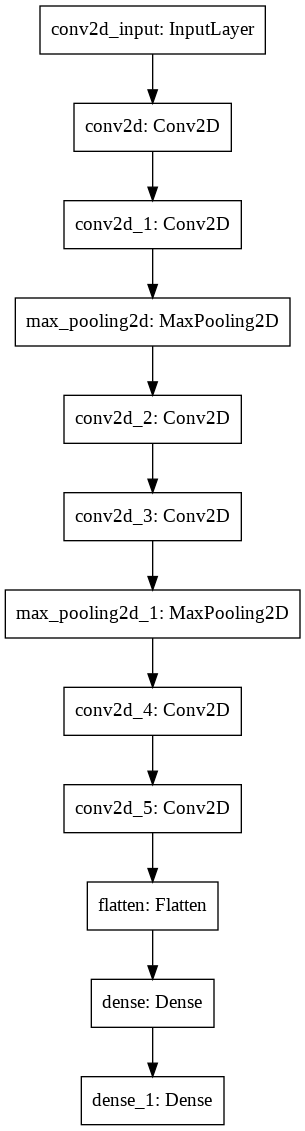

In [25]:
tf.keras.utils.plot_model(model)